# 사이킥런으로 수행하는 타이타닉 생존자 예측

**레이블 인코딩**

In [0]:
# 라이브러리 불러오기
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [6]:
# 훈련 데이터셋 확인
train = pd.read_csv('train.csv')
train.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [7]:
print('\n ### 훈련 데이터셋 정보 ### \n')
print(train.info())


 ### 훈련 데이터셋 정보 ### 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


In [8]:
### Age는 평균값으로 대체
train['Age'].fillna(train['Age'].mean(), inplace = True)

### 나머지는 'N'으로 대체
train['Cabin'].fillna('N', inplace=True)
train['Embarked'].fillna('N', inplace=True)
print('데이터 Null 값 개수: ', train.isnull().sum().sum())

데이터 Null 값 개수:  0


In [9]:
print('Sex 값 분포 :\n', train['Sex'].value_counts())
print('\nCabin 값 분포: \n', train['Cabin'].value_counts())
print('\nEmbarked 값 분포: \n', train['Embarked'].value_counts())

Sex 값 분포 :
 male      577
female    314
Name: Sex, dtype: int64

Cabin 값 분포: 
 N              687
B96 B98          4
C23 C25 C27      4
G6               4
D                3
              ... 
C54              1
D46              1
D47              1
F E69            1
D28              1
Name: Cabin, Length: 148, dtype: int64

Embarked 값 분포: 
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


In [10]:
train['Cabin'] = train['Cabin'].str[:1]
print(train['Cabin'].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


In [11]:
train.groupby(['Sex','Survived'])['Survived'].count().to_frame()

Survived
Sex    Survived          
female 0               81
       1              233
male   0              468
       1              109

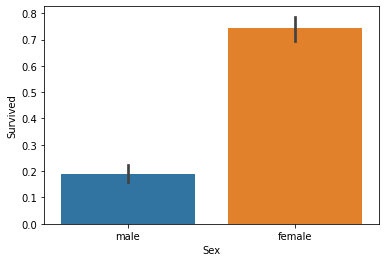

In [12]:
sns.barplot(x='Sex', y='Survived', data=train)

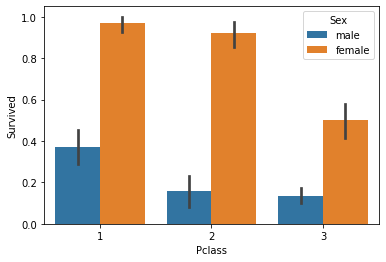

In [13]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train)

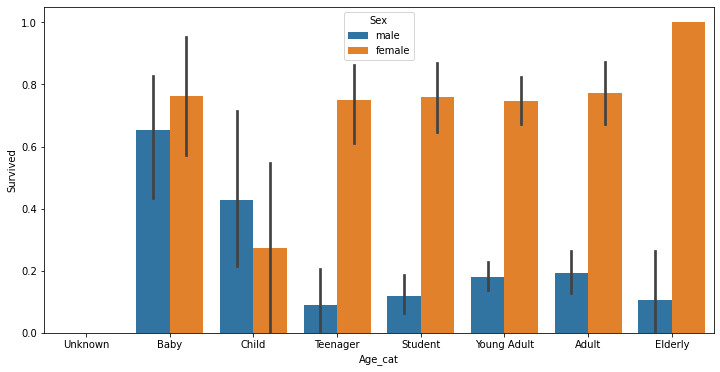

In [14]:
# 입력 age에 따라 구분 값을 반환하는 함수 설정. DataFrame의 apply lamda 식에 사용.

def get_category(age):
    cat = ''
    if age <= -1 : cat = 'Unknown'
    elif age <= 5 : cat = 'Baby'
    elif age <= 12 : cat = 'Child'
    elif age <= 18 : cat = 'Teenager'
    elif age <= 25 : cat = 'Student'
    elif age <= 35 : cat = 'Young Adult'
    elif age <= 60: cat = 'Adult'
    else : cat = 'Elderly'
    
    return cat

# 막대그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(12, 6))

# X축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category() 함수를 반환 값으로 지정
# get_category(x)는 입력값으로 Age 컬럼 값을 받아서 해당되는 cat 반환
train['Age_cat'] = train['Age'].apply(lambda x: get_category(x))
sns.barplot(x='Age_cat', y='Survived', hue='Sex', data=train, order=group_names)
train.drop('Age_cat', axis=1, inplace=True)

In [15]:
from sklearn.preprocessing import LabelEncoder

def encode_features(dataDF) :
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le = le.fit(dataDF[feature])
        dataDF[feature] = le.transform(dataDF[feature])
        
    return dataDF

train = encode_features(train)
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


In [0]:
# Null 처리 함수
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace=True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df


# 러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)
    return df


# 라벨 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = LabelEncoder()
        le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [0]:
# 원본 데이터 재로딩
titanic_df = pd.read_csv('train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop(['Survived'], axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 11)

In [20]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# DecisionTree, RandomForest, LogisticRegression을 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state=11)
rf_clf = RandomForestClassifier(random_state=11)
lr_clf = LogisticRegression()

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test, dt_pred)))
      
# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도 : {0:.4f}'.format(accuracy_score(y_test,rf_pred)))
      
# LogisticRegression 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegression 정확도 : {0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도 : 0.7877
RandomForestClassifier 정확도 : 0.8547
LogisticRegression 정확도 : 0.8492


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [21]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds):
    # 폴드 세트가 5개인 kFold 객체 생성, 폴드 수 만큼 예측결과 저장을 위한 리스트 객체 생성
    kfold = KFold(n_splits=folds)
    scores = []
    
    # kFold 교차검증 수행
    for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
        # X_train_df 데이터에서 교차검증별로 학습과 검증 데이터를 가리키는 인덱스 생성
        X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
        y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
        # Classifier 학습, 예측, 정확도 계산
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        scores.append(accuracy)
        print("교차검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
        # 5개 fold에서 평균 정확도 계산
    mean_score = np.mean(scores)
    print("평균 정확도 : {0:.4f}".format(mean_score))
    
# exec_kfold 호출
exec_kfold(dt_clf, 5)

교차검증 0 정확도: 0.7542
교차검증 1 정확도: 0.7809
교차검증 2 정확도: 0.7865
교차검증 3 정확도: 0.7697
교차검증 4 정확도: 0.8202
평균 정확도 : 0.7823


In [22]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv=5)
for iter_count, accuracy in enumerate(scores):
    print("교차검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))
    
print("평균정확도: {0: .4f}".format(np.mean(scores)))

교차검증 0 정확도: 0.7430
교차검증 1 정확도: 0.7753
교차검증 2 정확도: 0.7921
교차검증 3 정확도: 0.7865
교차검증 4 정확도: 0.8427
평균정확도:  0.7879


In [23]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth': [2, 3, 5, 10],
                        'min_samples_split' : [2, 3, 5],
                         'min_samples_leaf' : [1, 5, 8]}

grid_dclf = GridSearchCV(dt_clf, param_grid=parameters, scoring='accuracy', cv=5)
grid_dclf.fit(X_train, y_train)

print("GridSearch 최적 하이퍼 파라미터: ", grid_dclf.best_params_)
print("GridSearch 최고 정확도:{:.4f} ".format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearch의 최적 하이퍼파라미터로 학습된 Estimator로 예측 및 평가 수행
predictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('테스트 세트에서의 DecisionTreeClassifier 정확도: {0:.4f}'.format(accuracy))

GridSearch 최적 하이퍼 파라미터:  {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearch 최고 정확도:0.7992 
테스트 세트에서의 DecisionTreeClassifier 정확도: 0.8715
